# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
#from pyspark.sql import SparkContext
from pyspark.sql.functions import isnan, when, count, col, concat, concat_ws, asc, desc, explode, lit, min, max
from pyspark.sql.functions import sum as Fsum, split, udf, countDistinct, date_format, when, to_date
from pyspark.sql.types import IntegerType

import random
import re
import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, IndexToString, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder\
                    .master('local')\
                    .appName('SparkifyApp')\
                    .getOrCreate()
#sc = SparkContext()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
#when working on the full dataset create subset of records to do EDA on

**1st step** to examine the dataframe contents and data types below.

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Total number of records 
df.count()

286500

In [7]:
df.describe('userId', 'firstName', 'lastName', 'gender', 'status', 'level', 'registration').show()

+-------+-----------------+---------+--------+------+------------------+------+--------------------+
|summary|           userId|firstName|lastName|gender|            status| level|        registration|
+-------+-----------------+---------+--------+------+------------------+------+--------------------+
|  count|           286500|   278154|  278154|278154|            286500|286500|              278154|
|   mean|59682.02278593872|     null|    null|  null|210.05459685863875|  null|1.535358834084427...|
| stddev|109091.9499991047|     null|    null|  null| 31.50507848842214|  null| 3.291321616327586E9|
|    min|                 | Adelaida|   Adams|     F|               200|  free|       1521380675000|
|    max|               99|   Zyonna|  Wright|     M|               404|  paid|       1543247354000|
+-------+-----------------+---------+--------+------+------------------+------+--------------------+



In [8]:
df.describe('artist', 'song', 'length', 'auth', 'page', 'method').show()

+-------+------------------+--------------------+-----------------+----------+-------+------+
|summary|            artist|                song|           length|      auth|   page|method|
+-------+------------------+--------------------+-----------------+----------+-------+------+
|  count|            228108|              228108|           228108|    286500| 286500|286500|
|   mean| 551.0852017937219|            Infinity|249.1171819778458|      null|   null|  null|
| stddev|1217.7693079161374|                 NaN|99.23517921058361|      null|   null|  null|
|    min|               !!!|ÃÂg ÃÂtti Gr...|          0.78322| Cancelled|  About|   GET|
|    max| ÃÂlafur Arnalds|ÃÂau hafa slopp...|       3024.66567|Logged Out|Upgrade|   PUT|
+-------+------------------+--------------------+-----------------+----------+-------+------+



In [9]:
df.describe('sessionId', 'itemInSession', 'ts', 'userAgent', 'location').show()

+-------+-----------------+------------------+--------------------+--------------------+-----------------+
|summary|        sessionId|     itemInSession|                  ts|           userAgent|         location|
+-------+-----------------+------------------+--------------------+--------------------+-----------------+
|  count|           286500|            286500|              286500|              278154|           278154|
|   mean|1041.526554973822|114.41421291448516|1.540956889810483...|                null|             null|
| stddev|726.7762634630741|129.76726201140994|1.5075439608226302E9|                null|             null|
|    min|                1|                 0|       1538352117000|"Mozilla/5.0 (Mac...|       Albany, OR|
|    max|             2474|              1321|       1543799476000|Mozilla/5.0 (comp...|Winston-Salem, NC|
+-------+-----------------+------------------+--------------------+--------------------+-----------------+



From the above column counts it looks like every user log record has a 'userId' but some are missing user information like 'firstName', 'lastName', 'gender' and 'registration'.

In [10]:
#df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

In [11]:
#df.select('lastName').dropna().count()

In [12]:
#df.select('lastName').dropDuplicates().count()

In [13]:
#df.select('userId').dropDuplicates().count()

In [14]:
df.filter(df.lastName.isNull()).show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [15]:
df.filter(df.lastName.isNull()).count()

8346

In [16]:
df.filter(df.userId=='').count()

8346

Exclude records where userId='' since these will not provide any helpful information regarding cancelled. These users are either not yet logged in, or just browsing and cannot be identified as at a starting payment tier.

In [17]:
df = df.filter(df.userId!='')
df.count()

278154

Examining the available user interactions

In [18]:
df.select('auth','page', 'method').dropDuplicates().sort('page').show()

+---------+--------------------+------+
|     auth|                page|method|
+---------+--------------------+------+
|Logged In|               About|   GET|
|Logged In|          Add Friend|   PUT|
|Logged In|     Add to Playlist|   PUT|
|Logged In|              Cancel|   PUT|
|Cancelled|Cancellation Conf...|   GET|
|Logged In|           Downgrade|   GET|
|Logged In|               Error|   GET|
|Logged In|                Help|   GET|
|Logged In|                Home|   GET|
|Logged In|              Logout|   PUT|
|Logged In|            NextSong|   PUT|
|Logged In|         Roll Advert|   GET|
|Logged In|       Save Settings|   PUT|
|Logged In|            Settings|   GET|
|Logged In|    Submit Downgrade|   PUT|
|Logged In|      Submit Upgrade|   PUT|
|Logged In|         Thumbs Down|   PUT|
|Logged In|           Thumbs Up|   PUT|
|Logged In|             Upgrade|   GET|
+---------+--------------------+------+



In [19]:
df.select('sessionId', 'itemInSession', 'ts', 'userAgent', 'location').show(5)

+---------+-------------+-------------+--------------------+--------------------+
|sessionId|itemInSession|           ts|           userAgent|            location|
+---------+-------------+-------------+--------------------+--------------------+
|       29|           50|1538352117000|Mozilla/5.0 (Wind...|     Bakersfield, CA|
|        8|           79|1538352180000|"Mozilla/5.0 (Win...|Boston-Cambridge-...|
|       29|           51|1538352394000|Mozilla/5.0 (Wind...|     Bakersfield, CA|
|        8|           80|1538352416000|"Mozilla/5.0 (Win...|Boston-Cambridge-...|
|       29|           52|1538352676000|Mozilla/5.0 (Wind...|     Bakersfield, CA|
+---------+-------------+-------------+--------------------+--------------------+
only showing top 5 rows



In [20]:
df.filter(df.sessionId==1).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|   location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|         Al Di Meola|Logged In|  Natalee|     F|            0| Charles|286.40608| paid|Raleigh, NC|   PUT| NextSong|1536799770000|        1|      Roller Jubilee|   200|1538974195000|"Mozilla/5.0 (Win...|     2|
|      Karamelo Santo|Logged In|  Natalee|     F|            1| Charles|180.84526| paid|Raleigh, NC|   PUT| NextSong|1536799770000|        1|    El Bail

In [21]:
df.dropna(how='any',subset=['userId','sessionId']).count()

278154

In [22]:
#df = df.withColumn('ts_short', df.ts / lit(1000))
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month) 
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day) 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
df = df.withColumn('year', get_year(col('ts')))
df = df.withColumn('month', get_month(col('ts')))
df = df.withColumn('day', get_day(col('ts')))
df = df.withColumn('hour', get_hour(col('ts')))
cols = ["year","month","day"]
df = df.withColumn("date", to_date(concat_ws("-",*cols),"yyyy-MM-dd").cast("date"))

In [23]:
#registration timestamp
df = df.withColumn('reg_year', get_year(col('registration')))
df = df.withColumn('reg_month', get_month(col('registration')))
df = df.withColumn('reg_day', get_day(col('registration')))
cols = ["reg_year","reg_month","reg_day"]
df = df.withColumn("reg_date", to_date(concat_ws("-",*cols),"yyyy-MM-dd").cast("date"))

In [24]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', year='2018', month='10', day='1', hour='0', date=datetime.date(2018, 10, 1), reg_year='2018', reg_month='9', reg_day='28', reg_date=datetime.date(2018, 9, 28))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define cancelled

Once you've done some preliminary analysis, create a column `cancelled` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your cancelled, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined cancelled, perform some exploratory data analysis to observe the behavior for users who stayed vs users who cancelled. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
flag_cancelled = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('cancelled', flag_cancelled('page'))

flag_downgrade = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
df = df.withColumn('downgraded', flag_downgrade('page'))

In [26]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', year='2018', month='10', day='1', hour='0', date=datetime.date(2018, 10, 1), reg_year='2018', reg_month='9', reg_day='28', reg_date=datetime.date(2018, 9, 28), cancelled=0, downgraded=0)

In [27]:
from pyspark.sql import Window
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)
df = df.withColumn('pre_cancelled_events',Fsum('cancelled').over(windowval))
df = df.withColumn('pre_downgraded_events',Fsum('downgraded').over(windowval))

In [28]:
df.select(['userId','firstname','ts','page','level','downgraded','pre_downgraded_events','cancelled','pre_cancelled_events']
         ).where(df.pre_downgraded_events=='1').sort(['userId','ts'], ascending=False).dropDuplicates().show()

+------+----------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|userId| firstname|           ts|            page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|
+------+----------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|    96|Alexandria|1541722970000|Submit Downgrade| paid|         1|                    1|        0|                   0|
|    96|Alexandria|1541722969000|       Downgrade| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722956000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722674000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722415000|        NextSong| paid|         0|                    1|        0|                   0|
|    96|Alexandria|1541722188000

In [29]:
df.select(['userId','firstname','ts','page','level','downgraded','pre_downgraded_events','cancelled','pre_cancelled_events'
          ]).where(df.pre_cancelled_events=='1').sort(['userId','ts'], ascending=False).dropDuplicates().show()

+------+---------+-------------+--------------------+-----+----------+---------------------+---------+--------------------+
|userId|firstname|           ts|                page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|
+------+---------+-------------+--------------------+-----+----------+---------------------+---------+--------------------+
|    87|Christian|1540050556000|Cancellation Conf...| paid|         0|                    0|        1|                   1|
|    87|Christian|1540050538000|              Cancel| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050537000|           Downgrade| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050464000|            NextSong| paid|         0|                    0|        0|                   1|
|    87|Christian|1540050304000|            NextSong| paid|         0|                    0|        0|                   1|
|    87|

Checking that downgrade submission results in a change of paid tier

In [30]:
downgraded_users = [int(row.userId) for row in df.select('userId').where(
    df.page=='Submit Downgrade').dropDuplicates().collect()]

cancelled_users = [int(row.userId) for row in df.select('userId').where(
    df.page=='Cancellation Confirmation').dropDuplicates().collect()]

#free_users = 

In [31]:
downgraded_users[:5]

[54, 11, 30, 59, 85]

In [32]:
others_pivot = df.select('userId','level').dropDuplicates() \
    .filter(~df.userId.isin(downgraded_users)&~df.userId.isin(cancelled_users))\
    .groupBy("userId") \
    .pivot("level") \
    .count()

In [33]:
others_pivot.show(5)

+------+----+----+
|userId|free|paid|
+------+----+----+
|200002|   1|   1|
|100010|   1|null|
|     7|   1|null|
|   124|null|   1|
|    15|null|   1|
+------+----+----+
only showing top 5 rows



In [34]:
free_only_users = [int(row.userId) for row in others_pivot.select('userId').where(
    others_pivot.paid.isNull()).collect()]

In [35]:
free_only_users[:5]

[100010, 7, 154, 112, 64]

In [36]:
df = df.withColumn('user_type', \
    when(df.userId.isin(downgraded_users),lit('downgraded')) \
    .when(df.userId.isin(cancelled_users),lit('cancelled')) \
    .when(df.userId.isin(free_only_users),lit('free only')) \
     .otherwise(lit('paying')) )

In [37]:
backward_date = max('date') - 'date' 

In [38]:
df = df.withColumn('churn', \
    when(df.userId.isin(downgraded_users),lit(1)) \
    .when(df.userId.isin(cancelled_users),lit(1)) \
    .otherwise(lit(0)) )

Looking at an example of a user who downgraded, though it looks like this one downgraded and then upgraded again a while later.

In [39]:
df.select(['userId','firstname','sessionId','ts','page','level','downgraded','pre_downgraded_events']).where(
            (df.userId=='11') & (df.page!='NextSong')).sort('ts', ascending=False).count()

201

In [40]:
df.select(['userId','firstname','sessionId','ts','page','level','downgraded','pre_downgraded_events','cancelled',
    'pre_cancelled_events']). \
    where((df.userId=='11') & (df.page!='NextSong')).sort('ts', ascending=False).show(200)

+------+---------+---------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|userId|firstname|sessionId|           ts|            page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|
+------+---------+---------+-------------+----------------+-----+----------+---------------------+---------+--------------------+
|    11|      Zoe|     2092|1543308850000|       Thumbs Up| paid|         0|                    0|        0|                   0|
|    11|      Zoe|     2092|1543308631000|       Thumbs Up| paid|         0|                    0|        0|                   0|
|    11|      Zoe|     2092|1543306154000|       Thumbs Up| paid|         0|                    0|        0|                   0|
|    11|      Zoe|     2092|1543305128000| Add to Playlist| paid|         0|                    0|        0|                   0|
|    11|      Zoe|     2016|1542667700000|       Thumbs Up| paid|         0|              

In [41]:
df.select(['userId','firstname','sessionId','ts','page','level','downgraded','pre_downgraded_events','cancelled',
    'pre_cancelled_events','user_type']). \
    where((df.userId=='7') & (df.page!='NextSong')).sort('ts', ascending=False).show(200)

+------+---------+---------+-------------+---------------+-----+----------+---------------------+---------+--------------------+---------+
|userId|firstname|sessionId|           ts|           page|level|downgraded|pre_downgraded_events|cancelled|pre_cancelled_events|user_type|
+------+---------+---------+-------------+---------------+-----+----------+---------------------+---------+--------------------+---------+
|     7|   Maddox|     2119|1542955611000|      Thumbs Up| free|         0|                    0|        0|                   0|free only|
|     7|   Maddox|     2119|1542955331000|           Home| free|         0|                    0|        0|                   0|free only|
|     7|   Maddox|     1781|1542720620000|         Logout| free|         0|                    0|        0|                   0|free only|
|     7|   Maddox|     1781|1542719728000|           Home| free|         0|                    0|        0|                   0|free only|
|     7|   Maddox|     1781

Summarizing Data. Grouping the downgraded users' "pre downgrade" visits per user to see if there are any patterns in behaviour at the summary level.

In [42]:
#df.filter(df.user_type.isin(['free_only'])).head()

In [43]:
#New summary dataframe per user 
user_summary = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying']))). \
    groupBy("userId","user_type", "reg_date"). \
    agg(max("date").alias("max_date"), \
         min("date").alias("min_date"), \
         countDistinct("sessionId").alias("cnt_sessionId"), \
         count("itemInSession").alias("cnt_itemInSession") \
     )#truncate=False)

In [44]:
#summarize the page visit data per user
user_pivot = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying']))). \
    groupBy("userId") \
    .pivot("page") \
    .count()

In [45]:
#join the 2 together on userId
user_summary = user_summary.join(user_pivot, on=['userId'], how='inner')

Add new column to summary to calculate the length of membership to the sparkify before downgrading

In [46]:
#udfs to calculate the difference in days between the 1st user record and the last one before cancelled, or downgrade
date_diff = udf(lambda x,y: x - y)
delta_days = udf(lambda x: x.days)

In [47]:
#Add new column to summary to calculate the length of membership to the sparkify before downgrading
col_diff = date_diff(user_summary.max_date, user_summary.min_date)
user_summary = user_summary.withColumn('days_membership', delta_days(col_diff).cast(IntegerType()))

In [48]:
#user_summary = user_summary.withColumn('days_membership_int', user_summary.days_membership.cast('integer'))

In [49]:
#user_summary.describe()

In [50]:
user_summary.filter(user_summary.userId=='7').head()

Row(userId='7', user_type='free only', reg_date=datetime.date(2018, 9, 11), max_date=datetime.date(2018, 11, 23), min_date=datetime.date(2018, 10, 3), cnt_sessionId=7, cnt_itemInSession=201, About=None, Add Friend=1, Add to Playlist=5, Cancel=None, Cancellation Confirmation=None, Downgrade=None, Error=1, Help=1, Home=10, Logout=3, NextSong=150, Roll Advert=16, Save Settings=1, Settings=3, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=1, Thumbs Up=7, Upgrade=2, days_membership=51)

In [51]:
#user_summary.select('days_membership').dropDuplicates().show()

Convert to dataframe so that I can view graphs

In [52]:
#shrink 1st before feeding into graph
user_summary_pd = user_summary.toPandas()
user_summary_pd.head()

,userId,user_type,reg_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
0,100010,free only,2018-09-27,2018-11-21,2018-10-08,7,381,1.0,4.0,7.0,...,275,52.0,NaN,NaN,NaN,NaN,5.0,17.0,2.0,44
1,200002,paying,2018-09-06,2018-11-15,2018-10-01,6,474,3.0,4.0,8.0,...,387,7.0,NaN,3.0,NaN,1.0,6.0,21.0,2.0,45
2,125,cancelled,2018-08-01,2018-10-12,2018-10-12,1,11,NaN,NaN,NaN,...,8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,124,paying,2018-07-22,2018-11-30,2018-10-01,29,4825,7.0,74.0,118.0,...,4079,4.0,6.0,20.0,NaN,NaN,41.0,171.0,NaN,60
4,51,cancelled,2018-09-27,2018-10-17,2018-10-01,10,2464,2.0,28.0,52.0,...,2111,NaN,1.0,12.0,NaN,NaN,21.0,100.0,NaN,16


In [53]:
user_summary_pd.shape

(225, 27)

In [54]:
user_summary_pd_per_day = user_summary_pd.copy()
user_summary_pd_per_day.iloc[:,5:] = user_summary_pd_per_day.iloc[:,5:].div(
    user_summary_pd_per_day.days_membership, axis=0)
user_summary_pd_per_day.head()

,userId,user_type,reg_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
0,100010,free only,2018-09-27,2018-11-21,2018-10-08,0.159091,8.659091,0.022727,0.090909,0.159091,...,6.250000,1.181818,NaN,NaN,NaN,NaN,0.113636,0.386364,0.045455,1.0
1,200002,paying,2018-09-06,2018-11-15,2018-10-01,0.133333,10.533333,0.066667,0.088889,0.177778,...,8.600000,0.155556,NaN,0.066667,NaN,0.022222,0.133333,0.466667,0.044444,1.0
2,125,cancelled,2018-08-01,2018-10-12,2018-10-12,inf,inf,NaN,NaN,NaN,...,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,124,paying,2018-07-22,2018-11-30,2018-10-01,0.483333,80.416667,0.116667,1.233333,1.966667,...,67.983333,0.066667,0.1000,0.333333,NaN,NaN,0.683333,2.850000,NaN,1.0
4,51,cancelled,2018-09-27,2018-10-17,2018-10-01,0.625000,154.000000,0.125000,1.750000,3.250000,...,131.937500,NaN,0.0625,0.750000,NaN,NaN,1.312500,6.250000,NaN,1.0


In [55]:
user_summary_pd_per_session = user_summary_pd.copy()
user_summary_pd_per_session.iloc[:,5:] = user_summary_pd_per_session.iloc[:,5:].div(
    user_summary_pd_per_session.cnt_sessionId, axis=0)
user_summary_pd_per_session.head()

,userId,user_type,reg_date,max_date,min_date,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
0,100010,free only,2018-09-27,2018-11-21,2018-10-08,1.0,54.428571,0.142857,0.571429,1.000000,...,39.285714,7.428571,NaN,NaN,NaN,NaN,0.714286,2.428571,0.285714,6.285714
1,200002,paying,2018-09-06,2018-11-15,2018-10-01,1.0,79.000000,0.500000,0.666667,1.333333,...,64.500000,1.166667,NaN,0.500000,NaN,0.166667,1.000000,3.500000,0.333333,7.500000
2,125,cancelled,2018-08-01,2018-10-12,2018-10-12,1.0,11.000000,NaN,NaN,NaN,...,8.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,124,paying,2018-07-22,2018-11-30,2018-10-01,1.0,166.379310,0.241379,2.551724,4.068966,...,140.655172,0.137931,0.206897,0.689655,NaN,NaN,1.413793,5.896552,NaN,2.068966
4,51,cancelled,2018-09-27,2018-10-17,2018-10-01,1.0,246.400000,0.200000,2.800000,5.200000,...,211.100000,NaN,0.100000,1.200000,NaN,NaN,2.100000,10.000000,NaN,1.600000


In [56]:
user_summary_pd_per_day.shape

(225, 27)

(array([ 43.,   0.,   0.,  49.,   0.,   0.,  44.,   0.,   0.,  89.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

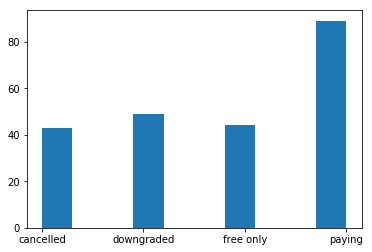

In [57]:
plt.hist(user_summary_pd.user_type)

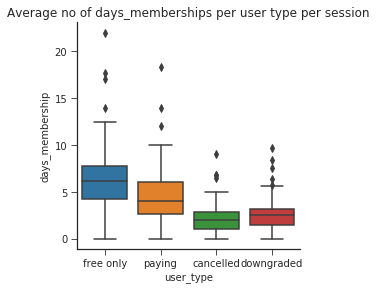

In [58]:
# cnt_sessionId	cnt_itemInSession	About	Add Friend	Add to Playlist	Cancel	Cancellation Confirmation	
# Downgrade	Error	Help	NextSong	Roll Advert	Save Settings	Settings	Submit Downgrade	Submit Upgrade	
# Thumbs Down	Thumbs Up	Upgrade	Home  Logout days_membership
y= 'days_membership'
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type',y = y,
                     data=user_summary_pd_per_session, kind='box')
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average no of {}s per user type per session'.format(y)); 

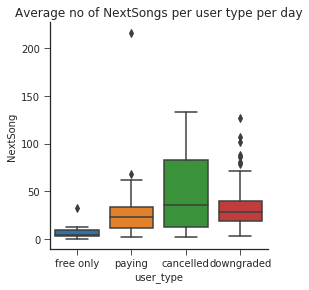

In [59]:
# cnt_sessionId	cnt_itemInSession	About	Add Friend	Add to Playlist	Cancel	Cancellation Confirmation	
# Downgrade	Error	Help	NextSong	Roll Advert	Save Settings	Settings	Submit Downgrade	Submit Upgrade	
# Thumbs Down	Thumbs Up	Upgrade	Home  Logout days_membership
y= 'NextSong'
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type',y = y,
                     data=user_summary_pd_per_day, kind='box')
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average no of {}s per user type per day'.format(y)); 

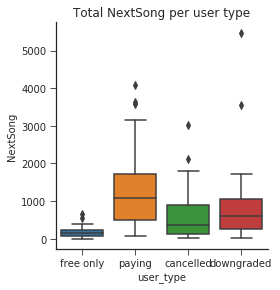

In [60]:

with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type', y = y,
                     data=user_summary_pd, kind='box')
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Total {} per user type'.format(y)); 

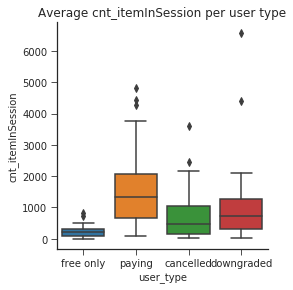

In [61]:
with sns.axes_style(style='ticks'):
    g=sns.factorplot(x='user_type',y = 'cnt_itemInSession',
                     data=user_summary_pd, kind='box')
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average {} per user type'.format('cnt_itemInSession')); 

In [62]:
user_summary_pd.max_date.max()

datetime.date(2018, 12, 3)

In [63]:
user_summary_pd.max_date.min()

datetime.date(2018, 10, 1)

In [64]:
user_summary_pd.days_membership.max()

60

In [65]:
#user_summary_pd_per_day.dtypes
pd.options.display.max_columns = user_summary_pd.shape[1]

In [66]:
user_summary_pd[user_summary_pd.user_type=='paying'].describe()

,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
count,89.000000,89.000000,77.000000,89.000000,88.000000,0.0,0.0,79.000000,56.000000,83.000000,89.000000,89.000000,89.000000,74.000000,57.000000,83.000000,0.0,65.0,85.000000,89.000000,65.000000,89.000000
mean,13.977528,1434.932584,3.051948,22.494382,34.431818,NaN,NaN,12.531646,2.250000,8.108434,50.348315,15.573034,1190.303371,12.121622,2.578947,8.433735,NaN,1.0,12.317647,65.831461,2.061538,48.280899
std,10.039669,1015.141882,2.025470,15.251769,25.237172,NaN,NaN,9.600795,1.365151,5.723320,36.721031,11.557060,853.043487,11.443671,1.668483,5.953463,NaN,0.0,10.465603,48.522075,1.273245,13.679770
min,1.000000,76.000000,1.000000,1.000000,2.000000,NaN,NaN,1.000000,1.000000,1.000000,2.000000,1.000000,65.000000,1.000000,1.000000,1.000000,NaN,1.0,1.000000,2.000000,1.000000,0.000000
25%,7.000000,651.000000,1.000000,11.000000,12.000000,NaN,NaN,5.000000,1.000000,4.000000,22.000000,6.000000,505.000000,3.000000,1.000000,3.500000,NaN,1.0,5.000000,28.000000,1.000000,44.000000
50%,12.000000,1322.000000,3.000000,20.000000,32.500000,NaN,NaN,10.000000,2.000000,7.000000,43.000000,13.000000,1086.000000,9.500000,2.000000,8.000000,NaN,1.0,10.000000,56.000000,2.000000,54.000000
75%,18.000000,2067.000000,4.000000,32.000000,50.500000,NaN,NaN,19.500000,3.000000,10.000000,71.000000,21.000000,1728.000000,18.500000,3.000000,12.000000,NaN,1.0,17.000000,87.000000,3.000000,57.000000
max,63.000000,4825.000000,9.000000,74.000000,118.000000,NaN,NaN,41.000000,7.000000,27.000000,176.000000,59.000000,4079.000000,50.000000,7.000000,28.000000,NaN,1.0,54.000000,303.000000,7.000000,60.000000


In [67]:
user_summary_pd[user_summary_pd.user_type=='downgraded'].describe()

,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
count,49.000000,49.000000,29.000000,44.000000,47.000000,0.0,0.0,49.000000,24.000000,44.000000,48.000000,45.000000,49.000000,38.000000,21.000000,46.000000,49.0,32.0,44.000000,48.000000,32.000000,49.000000
mean,11.591837,973.367347,3.655172,15.818182,24.361702,NaN,NaN,9.061224,1.833333,5.909091,34.645833,11.133333,800.755102,12.315789,1.952381,5.108696,1.0,1.0,11.068182,46.208333,2.156250,23.734694
std,12.846722,1124.503792,4.600278,18.209725,30.103752,NaN,NaN,10.699315,1.049500,6.386097,37.688810,11.207952,929.911880,11.601736,1.430950,6.219068,0.0,0.0,12.568691,62.859505,1.247174,15.342989
min,1.000000,26.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,2.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0.000000
25%,5.000000,317.000000,1.000000,4.000000,7.000000,NaN,NaN,4.000000,1.000000,2.000000,14.250000,4.000000,262.000000,3.250000,1.000000,2.000000,1.0,1.0,2.750000,13.500000,1.000000,12.000000
50%,8.000000,726.000000,2.000000,12.000000,16.000000,NaN,NaN,6.000000,1.000000,4.000000,27.000000,9.000000,598.000000,9.500000,1.000000,3.000000,1.0,1.0,7.000000,26.500000,2.000000,21.000000
75%,13.000000,1283.000000,4.000000,21.250000,31.500000,NaN,NaN,11.000000,3.000000,7.250000,41.250000,14.000000,1060.000000,15.750000,3.000000,6.000000,1.0,1.0,16.000000,56.000000,3.000000,36.000000
max,67.000000,6582.000000,20.000000,97.000000,172.000000,NaN,NaN,68.000000,4.000000,34.000000,222.000000,66.000000,5474.000000,46.000000,6.000000,38.000000,1.0,1.0,69.000000,333.000000,6.000000,56.000000


In [68]:
user_summary_pd[user_summary_pd.user_type=='cancelled'].describe()

,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,days_membership
count,43.000000,43.000000,22.000000,35.000000,41.000000,43.0,43.0,26.000000,17.000000,34.000000,42.000000,37.000000,43.000000,41.000000,22.000000,35.000000,0.0,21.0,39.000000,41.000000,28.000000,43.000000
mean,9.232558,785.186047,1.681818,14.742857,19.512195,1.0,1.0,9.423077,1.529412,5.205882,29.166667,11.108108,639.767442,14.878049,2.000000,5.942857,NaN,1.0,9.153846,34.463415,2.750000,21.372093
std,7.450910,835.461214,0.838727,10.995568,21.476874,0.0,0.0,7.398233,0.717430,5.580156,27.628120,9.039370,703.504555,19.961457,1.023533,4.582209,NaN,0.0,8.180653,38.766672,1.818119,16.877744
min,1.000000,11.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,NaN,1.0,1.000000,1.000000,1.000000,0.000000
25%,4.000000,153.500000,1.000000,6.000000,3.000000,1.0,1.0,3.000000,1.000000,1.000000,8.500000,4.000000,113.000000,3.000000,1.000000,2.500000,NaN,1.0,2.000000,8.000000,1.000000,7.500000
50%,7.000000,478.000000,1.500000,12.000000,11.000000,1.0,1.0,8.500000,1.000000,3.000000,18.500000,7.000000,377.000000,9.000000,2.000000,5.000000,NaN,1.0,6.000000,19.000000,2.000000,18.000000
75%,12.000000,1056.000000,2.000000,22.500000,30.000000,1.0,1.0,13.000000,2.000000,7.750000,49.500000,18.000000,883.000000,22.000000,3.000000,8.000000,NaN,1.0,15.500000,45.000000,4.000000,35.500000
max,34.000000,3603.000000,4.000000,47.000000,89.000000,1.0,1.0,26.000000,3.000000,28.000000,121.000000,41.000000,3028.000000,115.000000,4.000000,19.000000,NaN,1.0,35.000000,154.000000,7.000000,58.000000


In [69]:
user_summary.filter(user_summary.user_type=='cancelled').take(5)

[Row(userId='125', user_type='cancelled', reg_date=datetime.date(2018, 8, 1), max_date=datetime.date(2018, 10, 12), min_date=datetime.date(2018, 10, 12), cnt_sessionId=1, cnt_itemInSession=11, About=None, Add Friend=None, Add to Playlist=None, Cancel=1, Cancellation Confirmation=1, Downgrade=None, Error=None, Help=None, Home=None, Logout=None, NextSong=8, Roll Advert=1, Save Settings=None, Settings=None, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=None, Thumbs Up=None, Upgrade=None, days_membership=0),
 Row(userId='51', user_type='cancelled', reg_date=datetime.date(2018, 9, 27), max_date=datetime.date(2018, 10, 17), min_date=datetime.date(2018, 10, 1), cnt_sessionId=10, cnt_itemInSession=2464, About=2, Add Friend=28, Add to Playlist=52, Cancel=1, Cancellation Confirmation=1, Downgrade=23, Error=1, Help=12, Home=75, Logout=24, NextSong=2111, Roll Advert=None, Save Settings=1, Settings=12, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=21, Thumbs Up=100, Upgrade=None

In [ ]:
user_summary.filter(user_summary.userId=='15').head()

In [ ]:
#df.filter((df.userId=='30')).count()

In [ ]:
#df.filter((df.userId=='30')&(df.page=='NextSong')).count()

In [ ]:
#df.select('sessionId').filter((df.userId=='30')).dropDuplicates().count()

Producing the original dataframe with the maxdate per user as a new column

In [ ]:
df2 = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying']))).join(
    user_summary.select('userId','max_date'), on=['userId'], how='inner')
#df3 = df2.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
#                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
#                        (df.user_type.isin(['free only','paying'])))

In [ ]:
col_diff = date_diff(df2.max_date, df2.date)
df2 = df2.withColumn('backward_days', delta_days(col_diff).cast(IntegerType()))

In [ ]:
df3_summary = df2.groupBy("userId","user_type",'backward_days'). \
    agg(countDistinct("sessionId").alias("cnt_sessionId"), \
         count("itemInSession").alias("cnt_itemInSession") \
     )
user_pivot = df2. \
    groupBy("userId",'backward_days') \
    .pivot("page") \
    .count()
df3_summary = df3_summary.join(user_pivot, on=['userId','backward_days'], how='inner')

In [77]:
#join the 2 together on userId
df3_summary_pd = df3_summary.toPandas()
df3_summary_pd.head()

,userId,backward_days,user_type,cnt_sessionId,cnt_itemInSession,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,126,35,paying,1,17,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,3.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,0,paying,1,152,2.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,7.0,5.0,124.0,NaN,NaN,1.0,NaN,NaN,1.0,3.0,NaN
2,200004,42,paying,2,73,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
3,300002,7,downgraded,1,30,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,37,1,paying,1,99,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,85.0,1.0,NaN,NaN,NaN,NaN,1.0,4.0,NaN


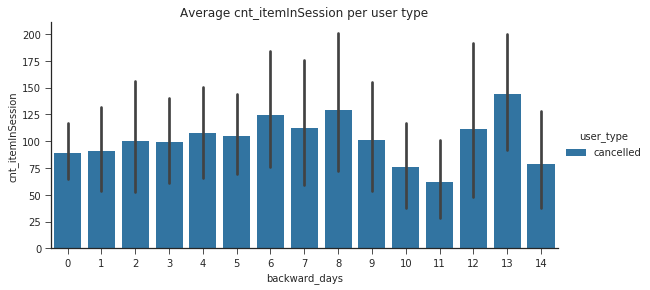

In [78]:
y= 'cnt_itemInSession'
data=df3_summary_pd[(df3_summary_pd.backward_days<15) & (df3_summary_pd.user_type=='cancelled')]
#sns.factorplot(data=df3_summary_pd, x="backward_days", y=y, hue="user_type", kind='scatter')
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", kind='bar', size=4, aspect=2)
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average {} per user type'.format(y)); 

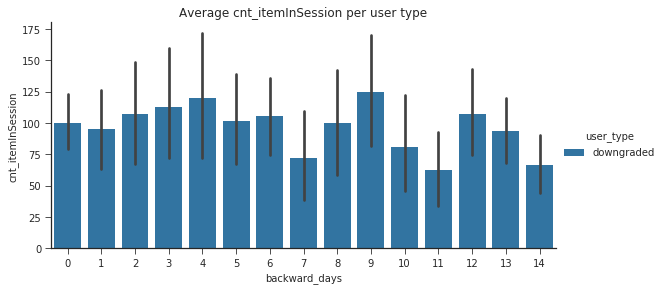

In [79]:
y= 'cnt_itemInSession'
data=df3_summary_pd[(df3_summary_pd.backward_days<15) & (df3_summary_pd.user_type=='downgraded')]
#sns.factorplot(data=df3_summary_pd, x="backward_days", y=y, hue="user_type", kind='scatter')
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", kind='bar', size=4, aspect=2)
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average {} per user type'.format(y)); 

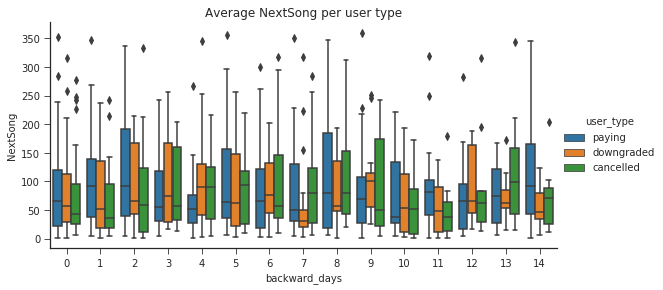

In [80]:
y= 'NextSong'
data=df3_summary_pd[(df3_summary_pd.backward_days<15) & (df3_summary_pd.user_type!='free only')]
#sns.factorplot(data=df3_summary_pd, x="backward_days", y=y, hue="user_type", kind='scatter')
with sns.axes_style(style='ticks'):
    g=sns.factorplot(data=data, x="backward_days", y=y, hue="user_type", kind='box', size=4, aspect=2)
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average {} per user type'.format(y)); 

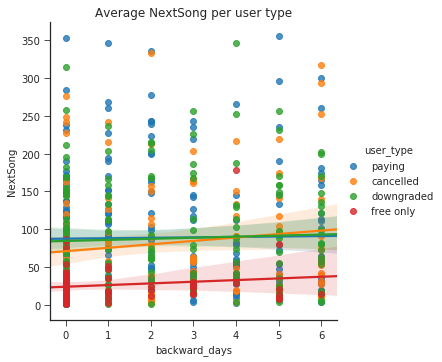

In [81]:
y= 'NextSong'
data=df3_summary_pd[df3_summary_pd.backward_days<7]
#sns.factorplot(data=df3_summary_pd, x="backward_days", y=y, hue="user_type", kind='scatter')
with sns.axes_style(style='ticks'):
    g=sns.lmplot(data=data, x="backward_days", y=y, hue="user_type")
    #g.set_axis_labels('user_type','days_membership')
    plt.title('Average {} per user type'.format(y)); 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [82]:
#page summary count per userid, sorted per day 

In [83]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- date: date (nullable = true)
 |-- reg_year: string (nullable = true)
 |-- reg_month: string (nullable = true)
 |-- reg_day: string (nullable = true)
 |-- reg

In [84]:
#add new feature 'cnt of days since last visit'

In [85]:
#New summary dataframe per user 
features = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['paying']))). \
    groupBy("userId","date","churn"). \
    agg(countDistinct("sessionId").alias("cnt_sessionId"), \
        count("itemInSession").alias("cnt_itemInSession") \
     )#truncate=False)

In [86]:
#summarize the page visit data per user
feature_pivot = df.filter(((df.user_type=='downgraded') & (df.pre_downgraded_events=='1')) | 
                        ((df.user_type=='cancelled') & (df.pre_cancelled_events=='1')) | 
                        (df.user_type.isin(['free only','paying']))). \
    groupBy("userId","date") \
    .pivot("page") \
    .count()

In [87]:
#join the 2 together on userId
features = features.join(feature_pivot, on=['userId','date'], how='inner')

In [88]:
features_sorted = features.sort(['userId','date'], ascending=True)
features_sorted.take(5)

[Row(userId='10', date=datetime.date(2018, 10, 8), churn=0, cnt_sessionId=1, cnt_itemInSession=70, About=None, Add Friend=3, Add to Playlist=1, Cancel=None, Cancellation Confirmation=None, Downgrade=None, Error=None, Help=None, Home=4, Logout=1, NextSong=57, Roll Advert=None, Save Settings=None, Settings=1, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=None, Thumbs Up=3, Upgrade=None),
 Row(userId='10', date=datetime.date(2018, 10, 18), churn=0, cnt_sessionId=1, cnt_itemInSession=345, About=None, Add Friend=3, Add to Playlist=6, Cancel=None, Cancellation Confirmation=None, Downgrade=3, Error=None, Help=None, Home=11, Logout=3, NextSong=297, Roll Advert=None, Save Settings=None, Settings=3, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=2, Thumbs Up=17, Upgrade=None),
 Row(userId='10', date=datetime.date(2018, 10, 19), churn=0, cnt_sessionId=1, cnt_itemInSession=104, About=2, Add Friend=2, Add to Playlist=1, Cancel=None, Cancellation Confirmation=None, Downgrade=None,

In [109]:
features_sorted = features_sorted.na.fill(value=0)
features_sorted.show(1)

+------+----------+-----+-------------+-----------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|      date|churn|cnt_sessionId|cnt_itemInSession|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+----------+-----+-------------+-----------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    10|2018-10-08|    0|            1|               70|    0|         3|              1|     0|                        0|        0|    0|   0|   4|     1|      57|          0|            0|       1|           

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the cancelled users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [89]:
#RandomForestClassifier
#split the data by user 
#time between visits


In [104]:
#randomly select users from list
def split_training_data(x_df, col, percentage):
    '''
    Inputs
    df : 
    col :
    percentage :
    
    Output
    train :
    test :
    '''

    # declaring list
    col_distinct = [row[col] for row in x_df.select(col).dropDuplicates().collect()]

    # initializing the value of n
    col_len = len(col_distinct)
    n = int(np.round((col_len)*percentage/100, 0))
    test_col = []

    # traversing and printing random elements
    for i in range(n):

        # end = " " so that we get output in single line
        test_col.append(random.choice(col_distinct))#, end = " ")
        
    test = x_df.filter(x_df[col].isin(test_col))
    train = x_df.filter(~x_df[col].isin(test_col))
    return train, test

In [105]:

train, test = split_training_data(features_sorted, 'userId', 20)

In [106]:
test.head()

Row(userId='100013', date=datetime.date(2018, 10, 2), churn=1, cnt_sessionId=1, cnt_itemInSession=52, About=None, Add Friend=None, Add to Playlist=2, Cancel=None, Cancellation Confirmation=None, Downgrade=None, Error=None, Help=1, Home=2, Logout=2, NextSong=40, Roll Advert=2, Save Settings=None, Settings=None, Submit Downgrade=None, Submit Upgrade=None, Thumbs Down=1, Thumbs Up=2, Upgrade=None)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.